In [1]:
import pandas as pd
import os
import random
import numpy as np
import matplotlib.pyplot as plt

In [2]:
train_dev_path = "data/tsv/train.tsv"
test_eval_path = "data/tsv/test.tsv"

data_df = pd.read_csv(train_dev_path, sep='\t')
test_df = pd.read_csv(test_eval_path, sep='\t')

In [6]:
data_df.head()

,sample_id,question,questionEntity,answerEntity,groundTruthAnswerEntity,answerEntityId,questionEntityId,groundTruthAnswerEntityId,correct,graph
0,0,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's return to Iran,Office of the Supreme Leader of Iran,Q7293530,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
1,1,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini's letter to Mikhail Gorbachev,Office of the Supreme Leader of Iran,Q5952984,Q794,Q16045000,False,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q417..."
2,2,Whst is the name of the head of state and high...,Iran,Ruhollah Khomeini,Office of the Supreme Leader of Iran,Q38823,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
3,3,Whst is the name of the head of state and high...,Iran,Office of the Supreme Leader of Iran,Office of the Supreme Leader of Iran,Q16045000,Q794,Q16045000,True,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4,4,Whst is the name of the head of state and high...,Iran,Mohammad Reza Pahlavi and Soraya,Office of the Supreme Leader of Iran,Q63195813,Q794,Q16045000,False,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."


In [7]:
# as we can see, test data doesn't have groundTruthAnswerEntity and correct (second one is target)
test_df.sample(5)

,sample_id,question,questionEntity,answerEntity,questionEntityId,answerEntityId,graph
1591,1591,"What is the best anime of 1988, according to K...","Anime, Kinema Junpo Award",Neon Genesis Evangelion,"Q1107, Q18388323",Q66834583,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q17'..."
3946,3946,What was the name of the second MLB team that ...,"Gerrit Cole, Major League Baseball",Cincinnati Reds,"Q5552563, Q1163715",Q1251984,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q30'..."
4510,4510,Which BTS member did not attend the 2020 Mnet ...,"BTS, MAMA Awards",T.O.P,"Q13580495, Q483271",Q495571,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q884..."
8669,8669,Who is the son of the 41st US president that a...,President of the United States,Barack Obama,Q11696,Q76,"{'nodes': [{'type': 'QUESTIONS_ENTITY', 'name_..."
4345,4345,Where is the oldest body of water that is not ...,"body of water, ocean",University of Tromsø – The Arctic University o...,"Q15324, Q9430",Q279724,"{'nodes': [{'type': 'INTERNAL', 'name_': 'Q191..."


## 1. Analysis of entities and target labels

In [21]:
data_df['question'].nunique()

3535

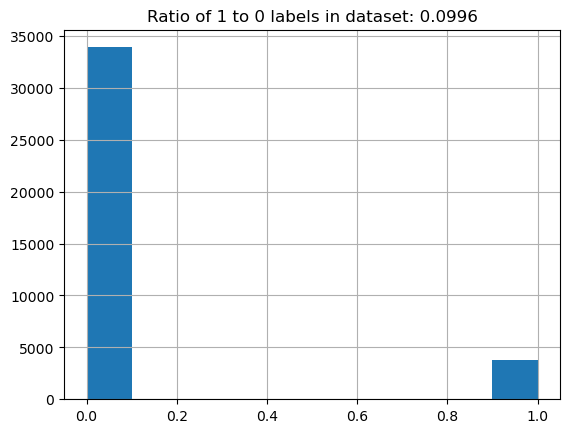

In [8]:
# dataset is naturally imbalanced, as a lot incorrect answers to same questions are provided
data_df['correct'] = data_df['correct'].astype(int)
data_df['correct'].hist()
plt.title(f"Ratio of 1 to 0 labels in dataset: {data_df['correct'].sum() / data_df.shape[0]:.4f}")
plt.show()

From this some ideas about data upsampling can come to mind, but problem is with WikiData, as quote:


`Wikidata is also large. In May 2019, 550GB bz2 compressed, 190GB 7z compressed. In March 2022, 1.4TB uncompressed. At this point Wikidata is growing faster than English language Wikipedia`

So we can't really afford to mine it for additional entities that correspond to real data. However, we don't really need to.

In [3]:
def get_unique_entries_commasep(df, colname):
    data = []
    for s in df[colname]:
        for entry in s.strip().split(','):
            data.append(entry)
    return set(data)

In [6]:
train_q = data_df['question'].unique()
test_q = test_df['question'].unique()

q_intersec = set(train_q) & set(test_q)

print(f"Portion of raw quetions in test that are present in train: {len(q_intersec) / len(test_q) : .2f}")

Portion of raw quetions in test that are present in train:  0.00


In [13]:
train_q_entities = get_unique_entries_commasep(data_df, 'questionEntity')
test_q_entities = get_unique_entries_commasep(test_df, 'questionEntity')

qe_intersec = set(train_q_entities) & set(test_q_entities)

print(f"Portion of question entities in test that are present in train: {len(qe_intersec) / len(test_q_entities) : .2f}")

Portion of question entities in test that are present in train:  0.33


In [4]:
train_a_entities = get_unique_entries_commasep(data_df, 'answerEntity')
test_a_entities = get_unique_entries_commasep(test_df, 'answerEntity')

ae_intersec = set(train_a_entities) & set(test_a_entities)

print(f"Portion of question entities in test that are present in train: {len(ae_intersec) / len(test_a_entities) : .2f}")

Portion of question entities in test that are present in train:  0.42


So interestengly, there is a large amount of questions & answer pairs in test that are not related to present in train. Answering on them requires general prior knowledge in model, which can be present only in LLMs pretrained on large corpora of text.

It also means that for upsampling purposes we don't really care about 'correctness' to source WikiData, as long as data that we synthesyze makes sense, it should be make things better.

Articles on augmentations:

- blogpost with common tricks: https://neptune.ai/blog/data-augmentation-nlp
- another blogpost: https://amitness.com/2020/05/data-augmentation-for-nlp/
- mixup for nlp: https://arxiv.org/pdf/2010.02394.pdf (generally improves things, but could make things worse)

Additionally, let's study how close train and test data are in terms of their representations


In [5]:
import torch
from transformers import BertTokenizer, BertModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# I am poor and my notebook is small kitty :)
tokenizer = BertTokenizer.from_pretrained('prajjwal1/bert-small')
model = BertModel.from_pretrained('prajjwal1/bert-small')

def get_bert_embeddings(texts):
    inputs = tokenizer(texts, return_tensors='pt', padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state[:, 0, :].numpy()  # Obtaining CLS token representations
    return embeddings

In [8]:
train_embeddings = get_bert_embeddings(train_q.tolist())
test_embeddings = get_bert_embeddings(test_q.tolist())

embeddings = np.concatenate([train_embeddings, test_embeddings], axis=0)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [6]:
import plotly.express as px

def plot_tsne(embeddings, texts, classes, title):
    tsne = TSNE(n_components=2, random_state=42)
    embeddings_tsne = tsne.fit_transform(embeddings)

    fig = px.scatter(
        embeddings_tsne, x=0, y=1,
        color=classes,
        hover_name=texts,
        title=title
    )
    fig.show()

In [11]:
plot_tsne(
    embeddings,
    train_q.tolist() + test_q.tolist(),
    ["train"]*len(train_q) + ["test"]*len(test_q),    
    title="t-SNE of dataset questions"
)

Seems like questions are really close in terms of their general thematic context, but might differ factually/in details. Let's look at entities in quetions/answers

In [16]:
plot_tsne(
    get_bert_embeddings(list(train_q_entities) + list(test_q_entities)),
    list(train_q_entities) + list(test_q_entities),
    ["train"]*len(train_q_entities) + ["test"]*len(test_q_entities),    
    title="t-SNE of dataset questions"
)

In [ ]:
# for some reason this crushes notebook, so I didn't leave any output
# but you can try :)
plot_tsne(
    get_bert_embeddings(list(train_a_entities) + list(test_a_entities)),
    list(train_a_entities) + list(test_a_entities),
    ["train"]*len(train_a_entities) + ["test"]*len(test_a_entities),    
    title="t-SNE of dataset questions"
)

## 2. Properties of graphs

Here we make an attempt to spot any difference between graphs for correct answers and incorrect (at least from analysis perspective on their structure).

In [61]:
from visualization.draw_random_question_graphs import split_node_labels
import networkx as nx

In [77]:
def get_graph(df, i):
    row = df.iloc[[i]]
    graph_json = eval(row["graph"].item())
    graph_json["directed"] = True

    graph = nx.node_link_graph(graph_json, )
    return graph

In [85]:
corr_rows = data_df[data_df["correct"] == 1]
wrong_rows = data_df[data_df["correct"] == 0]

In [86]:
corr_graphs = [get_graph(corr_rows, i) for i in range(len(corr_rows))]
wrong_graphs = [get_graph(wrong_rows, i) for i in range(len(wrong_rows))]

In [91]:
def collect_stats(graph):
    num_nodes = len(graph.nodes)
    num_edges = len(graph.nodes)

    avg_degree = sum(dict(graph.degree()).values()) / len(graph)

    try: # for some graphs this fails
        diam = nx.diameter(graph)
    except Exception:
        diam = -1

    density = nx.density(graph)
    betw_centrality = nx.betweenness_centrality(graph)

    return {
        "n_nodes": num_nodes,
        "n_edges": num_edges,
        "avg_degree": avg_degree,
        "diam": diam,
        "density": density,
        "betw_centr": betw_centrality
    }

corr_stats = [collect_stats(graph) for graph in corr_graphs]
wrong_stats = [collect_stats(graph) for graph in wrong_graphs]

In [96]:
corr_stats_df = pd.DataFrame(corr_stats)
wrong_stats_df = pd.DataFrame(wrong_stats)

In [102]:
corr_stats_df['label'] = 1
wrong_stats_df['label'] = 0
joint_df = pd.concat([corr_stats_df, wrong_stats_df], ignore_index=True)

c:\Users\seriy\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


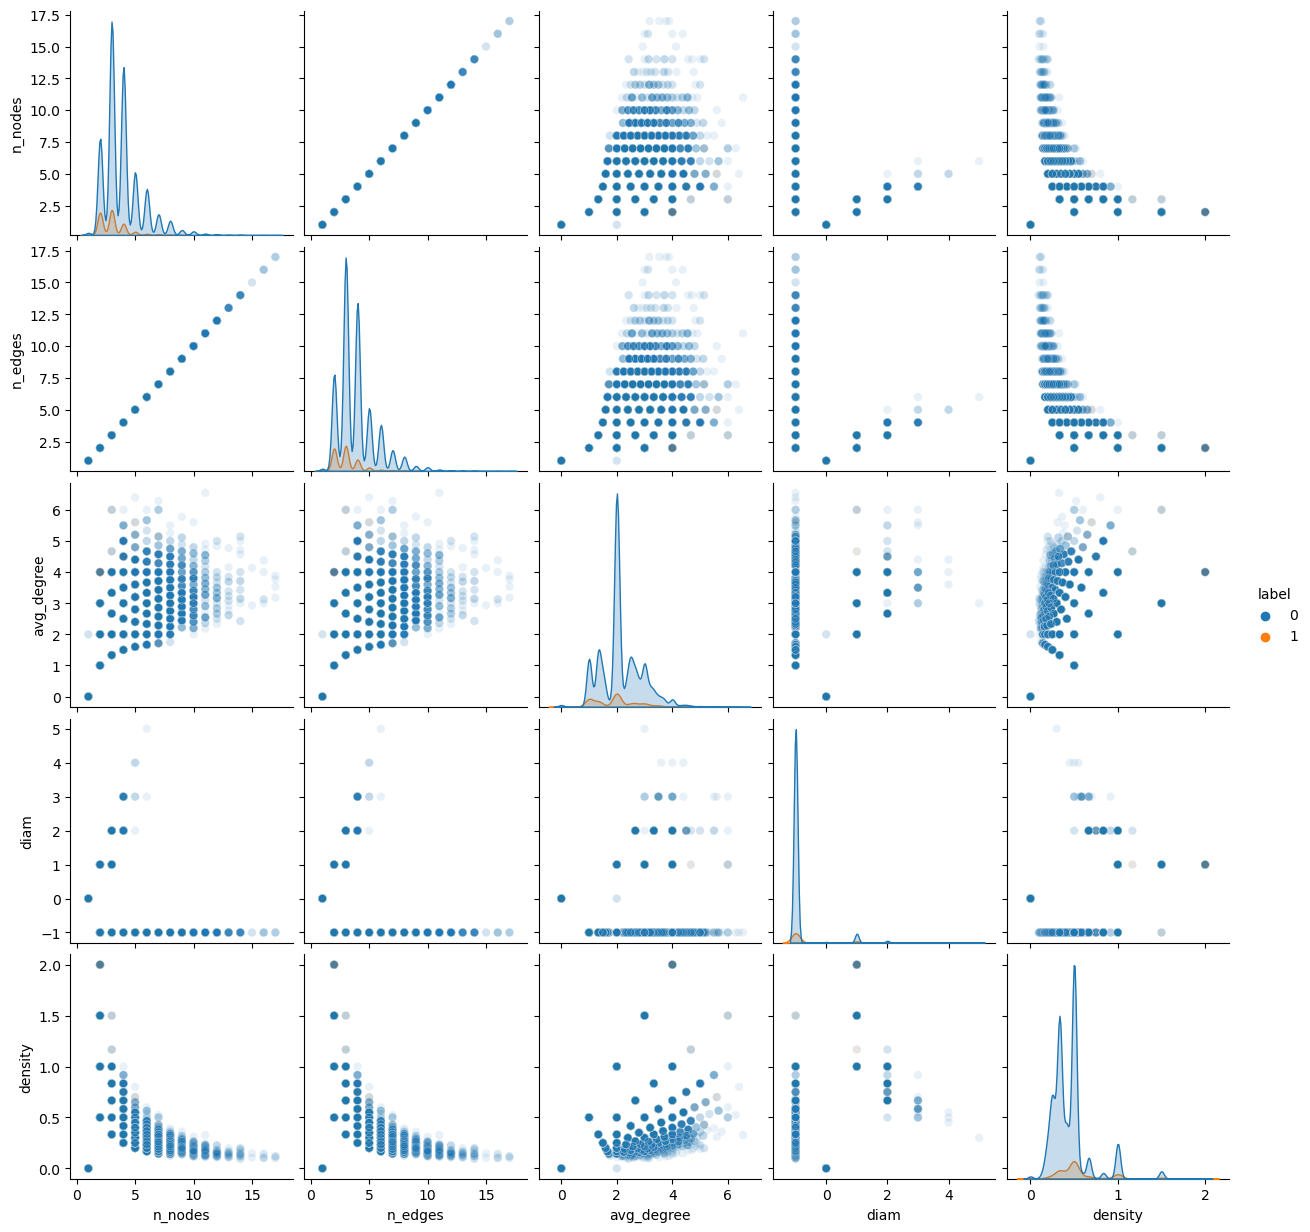

In [114]:
import seaborn as sns

sns.pairplot(joint_df, hue='label', plot_kws={'alpha': 0.1})
plt.show()

Unfortunately we can't really see anything promissing just from basic stats of graphs.